# Get an overview of the data

In [1]:
# all imports
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import tensorflow as tf

%matplotlib inline
sns.set_style("whitegrid")

In [2]:
# load the main dataset
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# load the meta data
holidays_events_df = pd.read_csv('holidays_events.csv')
oil_df = pd.read_csv('oil.csv')
stores_df = pd.read_csv('stores.csv')
transactions_df = pd.read_csv('transactions.csv')

## Peak at the data

Display the first few rows of the dataset to understand its structure and column names. Let's begin with the main dataset consisting of __train_df__ and __test_df__.

### Train and Test data

In [3]:
train_df.shape

(3000888, 6)

In [4]:
train_df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [5]:
test_df.shape

(28512, 5)

In [6]:
test_df.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


Let's add the description of the data from the kaggle page to see the column's meaning:
* __store_nbr__: identifies the store at which the products are sold
* __family__: identifies the type of product sold
* __onpromotion__: gives the total number of items in a product family that were being promoted at a store at a given date
* __sales__: gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips)

So we can see that the target column of __sales__ is missing in the test set. That means we will take only the __train_df__ for further analysis. But we have to investigate the categorical __family__ column in both sets before to make sure, that we are not missing any categorical value (important for the __LabelEncoder__).

In [7]:
# concat both sets together
dataset_df = pd.concat([train_df, test_df], axis=0)

# analyse the cardinality of the family column in both
dataset_df.family.value_counts()

AUTOMOTIVE                    91800
HOME APPLIANCES               91800
SCHOOL AND OFFICE SUPPLIES    91800
PRODUCE                       91800
PREPARED FOODS                91800
POULTRY                       91800
PLAYERS AND ELECTRONICS       91800
PET SUPPLIES                  91800
PERSONAL CARE                 91800
MEATS                         91800
MAGAZINES                     91800
LIQUOR,WINE,BEER              91800
LINGERIE                      91800
LAWN AND GARDEN               91800
LADIESWEAR                    91800
HOME CARE                     91800
HOME AND KITCHEN II           91800
BABY CARE                     91800
HOME AND KITCHEN I            91800
HARDWARE                      91800
GROCERY II                    91800
GROCERY I                     91800
FROZEN FOODS                  91800
EGGS                          91800
DELI                          91800
DAIRY                         91800
CLEANING                      91800
CELEBRATION                 

In [8]:
all_cat_values = set(dataset_df.family.unique().tolist())

Let's check if all the values are existing in the train set.

In [9]:
# analyse the cardinality of the family column in train_df
train_df.family.value_counts()

AUTOMOTIVE                    90936
HOME APPLIANCES               90936
SCHOOL AND OFFICE SUPPLIES    90936
PRODUCE                       90936
PREPARED FOODS                90936
POULTRY                       90936
PLAYERS AND ELECTRONICS       90936
PET SUPPLIES                  90936
PERSONAL CARE                 90936
MEATS                         90936
MAGAZINES                     90936
LIQUOR,WINE,BEER              90936
LINGERIE                      90936
LAWN AND GARDEN               90936
LADIESWEAR                    90936
HOME CARE                     90936
HOME AND KITCHEN II           90936
BABY CARE                     90936
HOME AND KITCHEN I            90936
HARDWARE                      90936
GROCERY II                    90936
GROCERY I                     90936
FROZEN FOODS                  90936
EGGS                          90936
DELI                          90936
DAIRY                         90936
CLEANING                      90936
CELEBRATION                 

In [10]:
train_cat_values = set(train_df.family.unique().tolist())

In [11]:
# look if one set does not contain a value from the other
added = list(sorted(train_cat_values - all_cat_values))
missing = list(sorted(all_cat_values - train_cat_values))
if added:
    print(f"{col}: added to the joined dataset: {added}")
if missing:
    print(f"{col}: missing from the joined dataset: {missing}")

We see no output from the print statements, so we have exact the same unique values in __train_df__ as in __test_df__. So we are not missing any values for a LabelEncoder. We can also see that we always have the same value counts of the unique values.

### Meta data

In [12]:
# Overview of shapes and column names
meta_dfs = [
    'holidays_events_df', 
    'oil_df',
    'stores_df',
    'transactions_df'
]

for meta in meta_dfs:
    print(meta)
    print(f"shape: {locals()[meta].shape}")
    print(f"columns: {locals()[meta].columns.tolist()}\n") 

holidays_events_df
shape: (350, 6)
columns: ['date', 'type', 'locale', 'locale_name', 'description', 'transferred']

oil_df
shape: (1218, 2)
columns: ['date', 'dcoilwtico']

stores_df
shape: (54, 5)
columns: ['store_nbr', 'city', 'state', 'type', 'cluster']

transactions_df
shape: (83488, 3)
columns: ['date', 'store_nbr', 'transactions']



In [13]:
holidays_events_df.head(3)

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False


The Description of the holidays_events data on kaggle says: 
* __transferred__: This means that originally it should be an event on that day but it was moved by government. 
* __type__: 
 * __Transfer__: Finding the moved day.  
 * __Bridge__: Extra days that are added to a holiday (e.g. extend the break across a long weekend)
 * __Workday__: A day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge

In [14]:
oil_df.head(3)

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97


Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.

In [15]:
stores_df.head(3)

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8


Store metadata, __cluster__ is a grouping of similar stores

In [16]:
transactions_df.head(3)

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358


No description given on kaggle. But I think these are the __payment transactions__ of the given store identified by __store_nbr__ on the given __date__.

__Additional Notes__ (from kaggle):
* Wages on 15th and last month day (2 wages per month)
* Earthquake 7.8 on April 16, 2016: People donated a lot which affected supermarket sales for several weeks after the earthquake.

## Data summary

Basic descriptive statistics like mean, median, standard deviation, and quartiles for numeric columns.

### Train and Test

In [17]:
train_df.describe()

,id,store_nbr,sales,onpromotion
count,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06
mean,1.500444e+06,2.750000e+01,3.577757e+02,2.602770e+00
std,8.662819e+05,1.558579e+01,1.101998e+03,1.221888e+01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,7.502218e+05,1.400000e+01,0.000000e+00,0.000000e+00
50%,1.500444e+06,2.750000e+01,1.100000e+01,0.000000e+00
75%,2.250665e+06,4.100000e+01,1.958473e+02,0.000000e+00
max,3.000887e+06,5.400000e+01,1.247170e+05,7.410000e+02


In [18]:
test_df.describe()

,id,store_nbr,onpromotion
count,2.851200e+04,28512.000000,28512.000000
mean,3.015144e+06,27.500000,6.965383
std,8.230850e+03,15.586057,20.683952
min,3.000888e+06,1.000000,0.000000
25%,3.008016e+06,14.000000,0.000000
50%,3.015144e+06,27.500000,0.000000
75%,3.022271e+06,41.000000,6.000000
max,3.029399e+06,54.000000,646.000000


### Meta data

In [19]:
holidays_events_df.describe()

,date,type,locale,locale_name,description,transferred
count,350,350,350,350,350,350
unique,312,6,3,24,103,2
top,2014-06-25,Holiday,National,Ecuador,Carnaval,False
freq,4,221,174,174,10,338


In [20]:
oil_df.describe()

,dcoilwtico
count,1175.000000
mean,67.714366
std,25.630476
min,26.190000
25%,46.405000
50%,53.190000
75%,95.660000
max,110.620000


In [21]:
stores_df.describe()

,store_nbr,cluster
count,54.000000,54.000000
mean,27.500000,8.481481
std,15.732133,4.693395
min,1.000000,1.000000
25%,14.250000,4.000000
50%,27.500000,8.500000
75%,40.750000,13.000000
max,54.000000,17.000000


In [22]:
transactions_df.describe()

,store_nbr,transactions
count,83488.000000,83488.000000
mean,26.939237,1694.602158
std,15.608204,963.286644
min,1.000000,5.000000
25%,13.000000,1046.000000
50%,27.000000,1393.000000
75%,40.000000,2079.000000
max,54.000000,8359.000000


# Exploratory Data Analysis

## Time plotting of train data

Time plot of store sales over the entire duration of the dataset.

### Plotting the sales over time

At first we have to take care of the different stores. So we can simply __groupby date__ and take the __mean__ of all stores for a general overview.

In [24]:
columns_to_plot = ['date', 'family', 'sales']

# make sure to have the date column in datetime format
train_df.date = pd.to_datetime(train_df.date)

# groupby and calculate mean
mean_train = train_df[columns_to_plot].groupby(['date']).mean().reset_index()

# mean lineplot
fig = px.line(mean_train, x='date', y='sales', title='Mean sales of all stores over time')
fig.show()

If we investigate the plot we can see:
* that every __January 1st__ the sales are going down to nearby __0__. Equadorians celebrate the New Year on __January 1st__, so the most stores are closed.
* that there is a __wider peak on April 16, 2016__, because there was the strong earthquake and the people bought more to donate it. This is also followed by a __second higher peak__ compared to the neighbour peaks on May 1st, 2016.
* We can also see that most maxima are on the weekend and most minima are in the middle/end of the workweek.

Let's investigate the week after the earthquake from April 16, 2016.

In [75]:
def get_top_3_families_of_daterange(from_date, to_date):
    # group by date and family
    quake_df = train_df[columns_to_plot].groupby(['date', 'family']).sum().reset_index()
    quake_df.set_index('date', inplace=True)

    # filter the week after earthquake 
    quake_df = quake_df.loc[from_date:to_date]

    # take the top 3 families on each day
    quake_df = quake_df.reset_index().set_index('family').groupby('date')['sales'].nlargest(3).to_frame()

    # plot article families as barchart
    quake_df.reset_index(inplace=True)
    quake_df.date = quake_df.date.apply(lambda x: x.strftime('%Y-%m-%d'))
    return quake_df

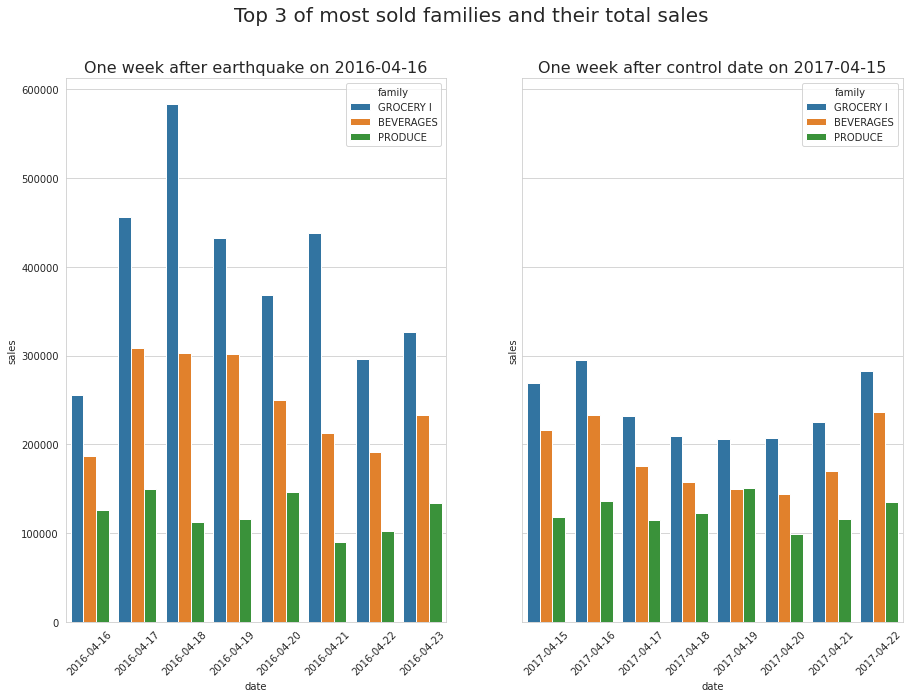

In [87]:
# get filtered and preprocessed dataframes
quake_df = get_top_3_families_of_week('2016-04-16', '2016-04-23')
compare_df = get_top_3_families_of_week('2017-04-15', '2017-04-22')

# plot both dataframes as subplots
fig, axes = plt.subplots(1, 2, figsize=(15,10), sharey=True)

# plot earthquake data
sns.barplot(x="date", y="sales", data=quake_df, hue="family", ax=axes[0])
axes[0].set_title('One week after earthquake on 2016-04-16', 
                  fontsize=16)

# plot control data one year later
sns.barplot(x="date", y="sales", data=compare_df, hue="family", ax=axes[1])
axes[1].set_title('One week after control date on 2017-04-15', 
                  fontsize=16)

# set xtick rotation
[[tick.set_rotation(45) for tick in ax.get_xticklabels()] for ax in axes]

# set main title
fig.suptitle("Top 3 of most sold families and their total sales", fontsize='20')
plt.show()  

Here we can clearly see that the sales from the family __GROCERY I__ and __BEVERAGES__ are significantly higher during the earthquake week compared to a normal week. However, The sales of the __PRODUCE__ family remained at a similar level on both weeks. This is an indication that people donated a lot of groceries and beverages.

## Meta data plotting

# Data Preprocessing

## Date formatting

Ensuring that the date column is in a proper datetime format, as this is crucial for time-based analysis.

## Handling missing values

Identification and handling of missing values, as they can impact forecasting accuracy (interpolation and forward/backward filling)

## Outlier detection

Detection and dealing with outliers that can adversely affect the model's performance.

## Feature engineering

Building of additional features like Year, day and month as separate column for the date. Also converting meta data in, e.g. binary indicators, could improve the performance of the model.

# Exploring Seasonality and Trends

## Decomposition

Time series decomposition to separate the series into its trend, seasonal, and residual components.

## Seasonal subseries plots

Visualization of the seasonal patterns (subseries plots for different seasons or months).

# Correlation Analysis

Calculation and plotting of the correlation matrix between store sales, oil price, and other relevant features.

# Feature Selection

Decision of factors to include in the forecasting model based on correlation analysis, seasonality and trends.

# Model Architecture

Baseline model with simple architecture (will be extended in the next sections).

# Training and Evaluation

# Hyperparameter Optimization and Model Improvement

## GridSearch of Hyperparameters

Baseline

## Extention of Baseline architecture

More complex version of the tuned baseline model to evaluate if the complex model architecture increases performance.

# Submission